In [25]:
import numpy as np
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
plt.style.use('dark_background')

In [26]:
X = fetch_california_housing()['data'][:600, :]

In [27]:
y = fetch_california_housing()['target'][:600]*10

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.4)

In [29]:
display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(360, 8)

(360,)

(240, 8)

(240,)

In [30]:
def mse(y_train, y_test):
  return np.mean(np.power(y_train - y_test, 2))

In [31]:
class MyGradientBoostig:

  def __init__(self, max_depth=None):
    self.max_depth_ = max_depth
    self.tree_ = {}

  def mse(self, y_pred, y_test):
    return np.mean(np.power(y_pred - y_test, 2))

  def fit(self, X, y, tree_path='0'):

    if len(tree_path) - 1 == self.max_depth_ or X.shape[0] <= 1:
      self.tree_[tree_path] = np.mean(y)
      return

    min_mse = None
    best_split = None

    for feature in range(X.shape[1]):
      for value in sorted(set(X[:, feature])):

        treshold = X[:, feature] <= value

        X1, y1 = X[treshold], y[treshold]
        X2, y2 = X[~treshold], y[~treshold]

        mse1 = self.mse(y1, np.mean(y1))
        mse2 = self.mse(y2, np.mean(y2))
        weight1 = y1.shape[0]/y.shape[0]
        weight2 = y2.shape[0]/y.shape[0]

        weighted_mse = mse1 * weight1 + mse2 * weight2

        if min_mse is None or weighted_mse < min_mse:
          min_mse = weighted_mse
          best_split = (feature, value)

    feature, value = best_split
    split_condition = X[:, feature] <= value
    X1, y1, X2, y2 = X[split_condition], y[split_condition],\
                      X[~split_condition], y[~split_condition]

    self.tree_[tree_path] = best_split

    self.fit(X1, y1, tree_path=tree_path + '0')
    self.fit(X2, y2, tree_path=tree_path + '1')


  def predict(self, X):
      results = []
      for i in range(X.shape[0]):
        tree_path ='0'
        while True:
          value_for_path = self.tree_[tree_path]
          if type(value_for_path) != tuple:
            result = value_for_path
            break
          feature, value = value_for_path
          if X[i, feature] <= value:
            tree_path += '0'
          else:
            tree_path += '1'
        results.append(result)
      return np.array(results)


In [32]:
class GradientBoostingRegressorFromScratch:

    def fit(self, X, y):

        self.trees = [] # Create a list to store trees

        for i in range(100):
            tree = MyGradientBoostig(15)
            tree.fit(X, y - self.predict(X)) # Fit the tree to data
            self.trees.append(tree) # Add the tree to the list of trees

    def predict(self, X):

        # Create array to store predictions
        trees_predictions = np.zeros((len(X), len(self.trees)))

        # Predict for each observation for each tree
        for i, tree in enumerate(self.trees):

          # Predict with a tree and multiply by learning rate
          trees_predictions[:, i] = tree.predict(X) * (1 if i == 0 else 0.1)

        # Return a sum of all trees predictions for each observation
        return np.sum(trees_predictions, axis=1)

In [33]:
tree = MyGradientBoostig(8)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [34]:
mse(y_pred, y_test)

37.51117383269007

In [35]:
display(y_pred.shape, y_test.shape)

(240,)

(240,)

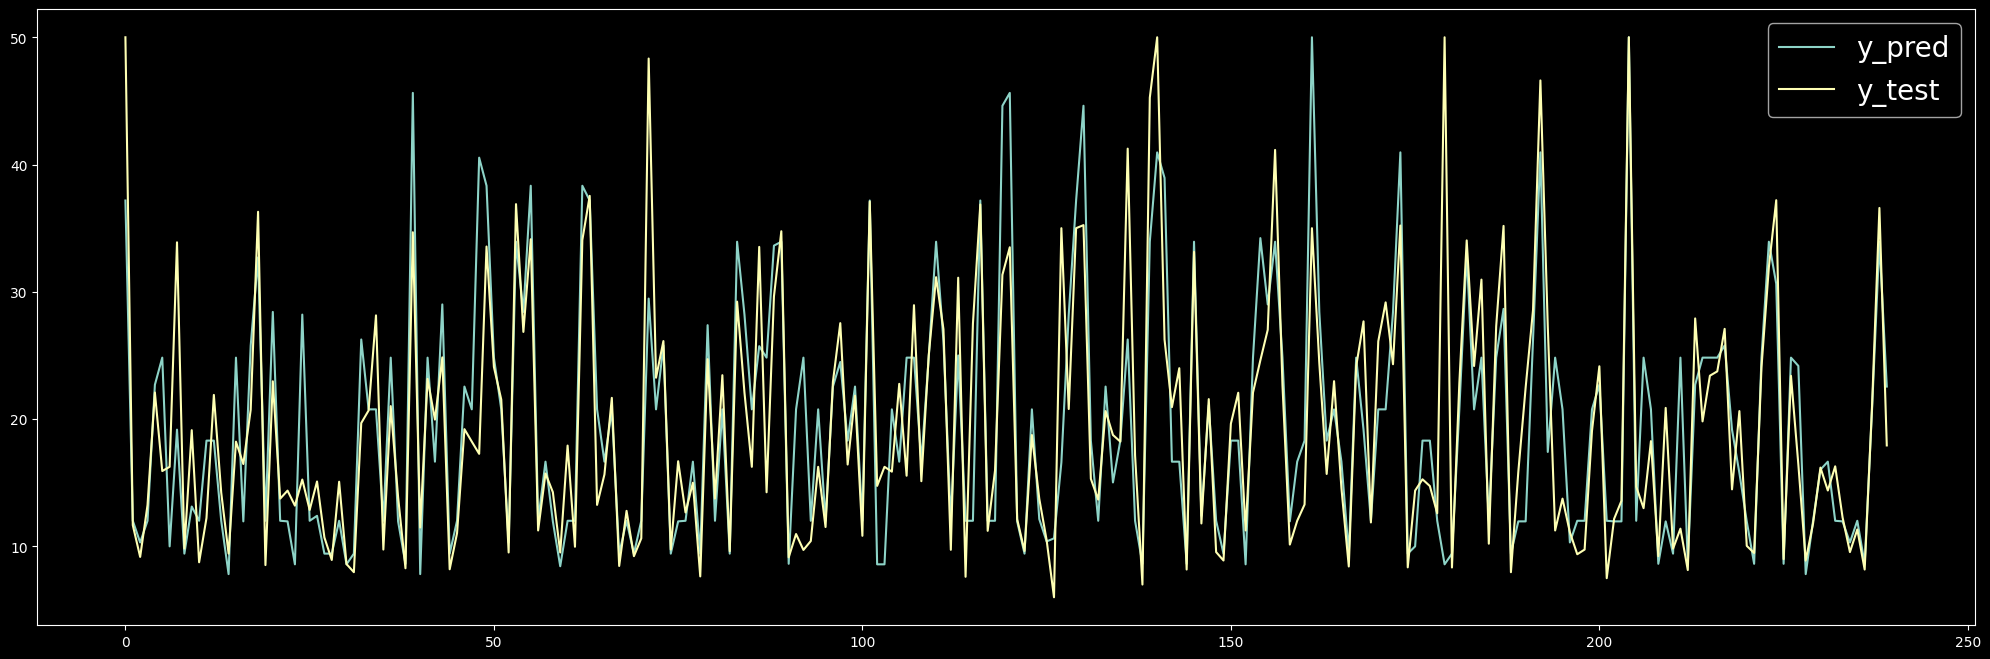

In [36]:
plt.figure(figsize=(25,8))
plt.plot(y_pred, label='y_pred')
plt.plot(y_test, label='y_test')
plt.legend(fontsize=20)

In [37]:
from sklearn.ensemble import GradientBoostingRegressor
np.random.seed(42)
sklearn_model = GradientBoostingRegressor()
sklearn_model.fit(X_train, y_train)
y_pred_sklrn = sklearn_model.predict(X_test)
mse(y_test, y_pred_sklrn)

24.143069776664323

In [38]:
mse(y_test, y_pred)

37.51117383269007

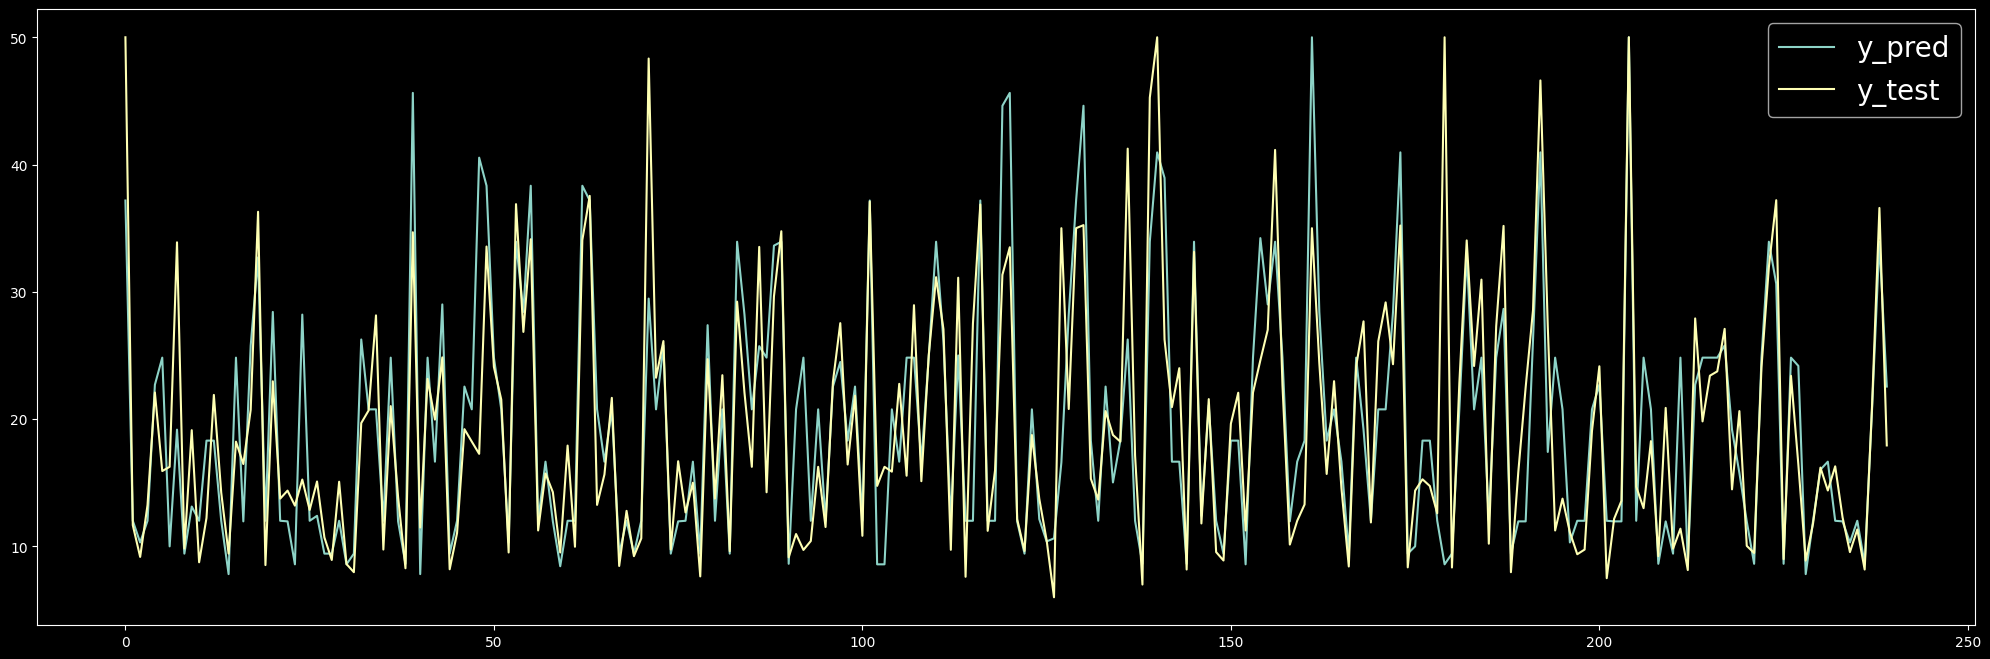

In [39]:
plt.figure(figsize=(25,8))
plt.plot(y_pred, label='y_pred')
plt.plot(y_test, label='y_test')
plt.legend(fontsize=20)

In [40]:
class MyGradientBosstingTree:

  def __init__(self, max_depth=20):
    self.max_depth = max_depth
    self.tree = {}

  def mse(self, y_pred, y_true):
    return np.mean(np.power(y_pred - y_true, 2))

  def fit(self, X, y, tree_path='0'):

    min_mse = None
    best_split = None

    if len(tree_path) - 1 == self.max_depth or X.shape[0] <= 1:
      self.tree[tree_path] = np.mean(y)
      return

    for feature in range(X.shape[1]):
      for value in sorted(set(X[:, feature])):
        treshold = X[:, feature] <= value

        X1, y1, X2, y2 = X[treshold], y[treshold],\
                          X[~treshold], y[~treshold]

        mse1 = self.mse(y1, np.mean(y1))
        mse2 = self.mse(y2, np.mean(y2))

        weight1 = y1.shape[0]/y.shape[0]
        weight2 = y2.shape[0]/y.shape[0]

        mse_weighted = mse1 * weight1 + mse2 * weight2

        if min_mse is None or min_mse > mse_weighted:
          min_mse = mse_weighted
          best_split = (feature, value)

    feature, value = best_split
    split_condition = X[:, feature] <= value

    X1, y1, X2, y2 = X[split_condition], y[split_condition],\
                      X[~split_condition], y[~split_condition]

    self.tree[tree_path] = best_split

    self.fit(X1, y1, tree_path = tree_path + '0')
    self.fit(X2, y2, tree_path = tree_path + '1')

  def predict(self, X):
    results = []
    for i in range(X.shape[0]):
      tree_path = '0'
      while True:
        value_tree_path = self.tree[tree_path]
        if type(value_tree_path) != tuple:
          result = value_tree_path
          break
        feature, value = value_tree_path
        if X[i, feature] <= value:
          tree_path += '0'
        else:
          tree_path += '1'
      results.append(result)
    return np.array(results)


In [41]:
class MyGradienBoostingForest:

  def __init__(self, trees=8):
    self.count_trees = trees

  def fit(self, X, y):
    self.trees = []
    for i in range(self.count_trees ):
      tree = MyGradientBosstingTree(8)
      tree.fit(X, y - self.predict(X))
      self.trees.append(tree)

  def predict(self, X):
    trees_predictions = np.zeros((X.shape[0], len(self.trees)))
    for i, tree in enumerate(self.trees):
      trees_predictions[:, i] = tree.predict(X) * (1 if i == 0 else 0.1)
    return np.sum(trees_predictions, axis=1)


In [42]:
tree = MyGradientBosstingTree(8)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


37.51117383269007

In [46]:
class MyForest:

  def __init__(self, cnt_trees=10):
    self.cnt_trees = cnt_trees

  def fit(self, X, y):
    self.trees = []
    for i in tqdm(range(self.cnt_trees)):
      tree = MyGradientBosstingTree(15)
      tree.fit(X, y - self.predict(X))
      self.trees.append(tree)

  def predict(self, X):
    trees_predictions = np.zeros((X.shape[0], len(self.trees)))
    for i, tree in enumerate(self.trees):
      trees_predictions[:, i] = tree.predict(X) * (1 if i == 0 else 0.1)
    return np.sum(trees_predictions, axis=1)


In [47]:
garden = MyForest(5)
garden.fit(X_train, y_train)
y_pred = garden.predict(X_test)

  0%|          | 0/5 [00:00<?, ?it/s]

In [49]:
mse(y_test, y_pred)

43.102725245746406

In [48]:
cnt_forest=5
mse_predicts = []
for i in tqdm(range(1, cnt_forest)):
  garden = MyForest(i)
  garden.fit(X_train, y_train)
  y_pred = garden.predict(X_test)
  mse_predicts.append(mse(y_test, y_pred))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [67]:
for i, j in tree.tree.items():
  if len(i) == 4 and type(j) == tuple:
    print(i, j)

0000 (0, 2.9018)
0001 (0, 1.4103)
0010 (0, 4.1458)
0011 (7, -122.26)
0100 (2, 7.256130790190736)
0101 (0, 5.9849)
0110 (0, 5.338)
0111 (5, 2.53)
